In [109]:
%load_ext autoreload
%autoreload 2
import os
import sys
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn as imb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from rdkit import Chem
import seaborn as sns
from rdkit.Chem import Draw
from imblearn.under_sampling import RandomUnderSampler
import random
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
smile_prop_df = pd.read_csv('/Users/radhi/Desktop/CAPSTONE_DATA/NEK_data_4Berkeley/NEK5/NEK5_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

# Reading in the training set (folds 1-4) and the test set (fold 5)
smile_prop_train = smile_prop_df[smile_prop_df['fold'] != 'fold5'].drop(columns=['fold'])
smile_prop_test = smile_prop_df[smile_prop_df['fold'] == 'fold5'].drop(columns=['fold'])

# Converting the SMILES to RDKit mol objects and assigning name and activity to each mol object
mol_train = []
for i in smile_prop_train.index:
    m = Chem.MolFromSmiles(smile_prop_train.loc[i, 'base_rdkit_smiles'])
    if m:
        m.SetProp("_Name", smile_prop_train.loc[i, 'compound_id'])
        m.SetProp("Active", str(smile_prop_train.loc[i, 'active']))
        mol_train.append(utils.normalize(m))

mol_test = []
for i in smile_prop_test.index:
    m = Chem.MolFromSmiles(smile_prop_test.loc[i, 'base_rdkit_smiles'])
    if m:
        m.SetProp("_Name", smile_prop_test.loc[i, 'compound_id'])
        m.SetProp("Active", str(smile_prop_test.loc[i, 'active']))
        mol_test.append(utils.normalize(m))


[20:11:40] Initializing MetalDisconnector
[20:11:40] Running MetalDisconnector
[20:11:40] Initializing Normalizer
[20:11:40] Running Normalizer
[20:11:40] Running LargestFragmentChooser
[20:11:40] Running Uncharger
[20:11:40] Initializing MetalDisconnector
[20:11:40] Running MetalDisconnector
[20:11:40] Initializing Normalizer
[20:11:40] Running Normalizer
[20:11:40] Initializing MetalDisconnector
[20:11:40] Running MetalDisconnector
[20:11:40] Initializing Normalizer
[20:11:40] Running Normalizer
[20:11:40] Running LargestFragmentChooser
[20:11:40] Running Uncharger
[20:11:40] Initializing MetalDisconnector
[20:11:40] Running MetalDisconnector
[20:11:40] Initializing Normalizer
[20:11:40] Running Normalizer
[20:11:40] Initializing MetalDisconnector
[20:11:40] Running MetalDisconnector
[20:11:40] Initializing Normalizer
[20:11:40] Running Normalizer
[20:11:40] Running LargestFragmentChooser
[20:11:40] Running Uncharger
[20:11:40] Initializing MetalDisconnector
[20:11:40] Running MetalD

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


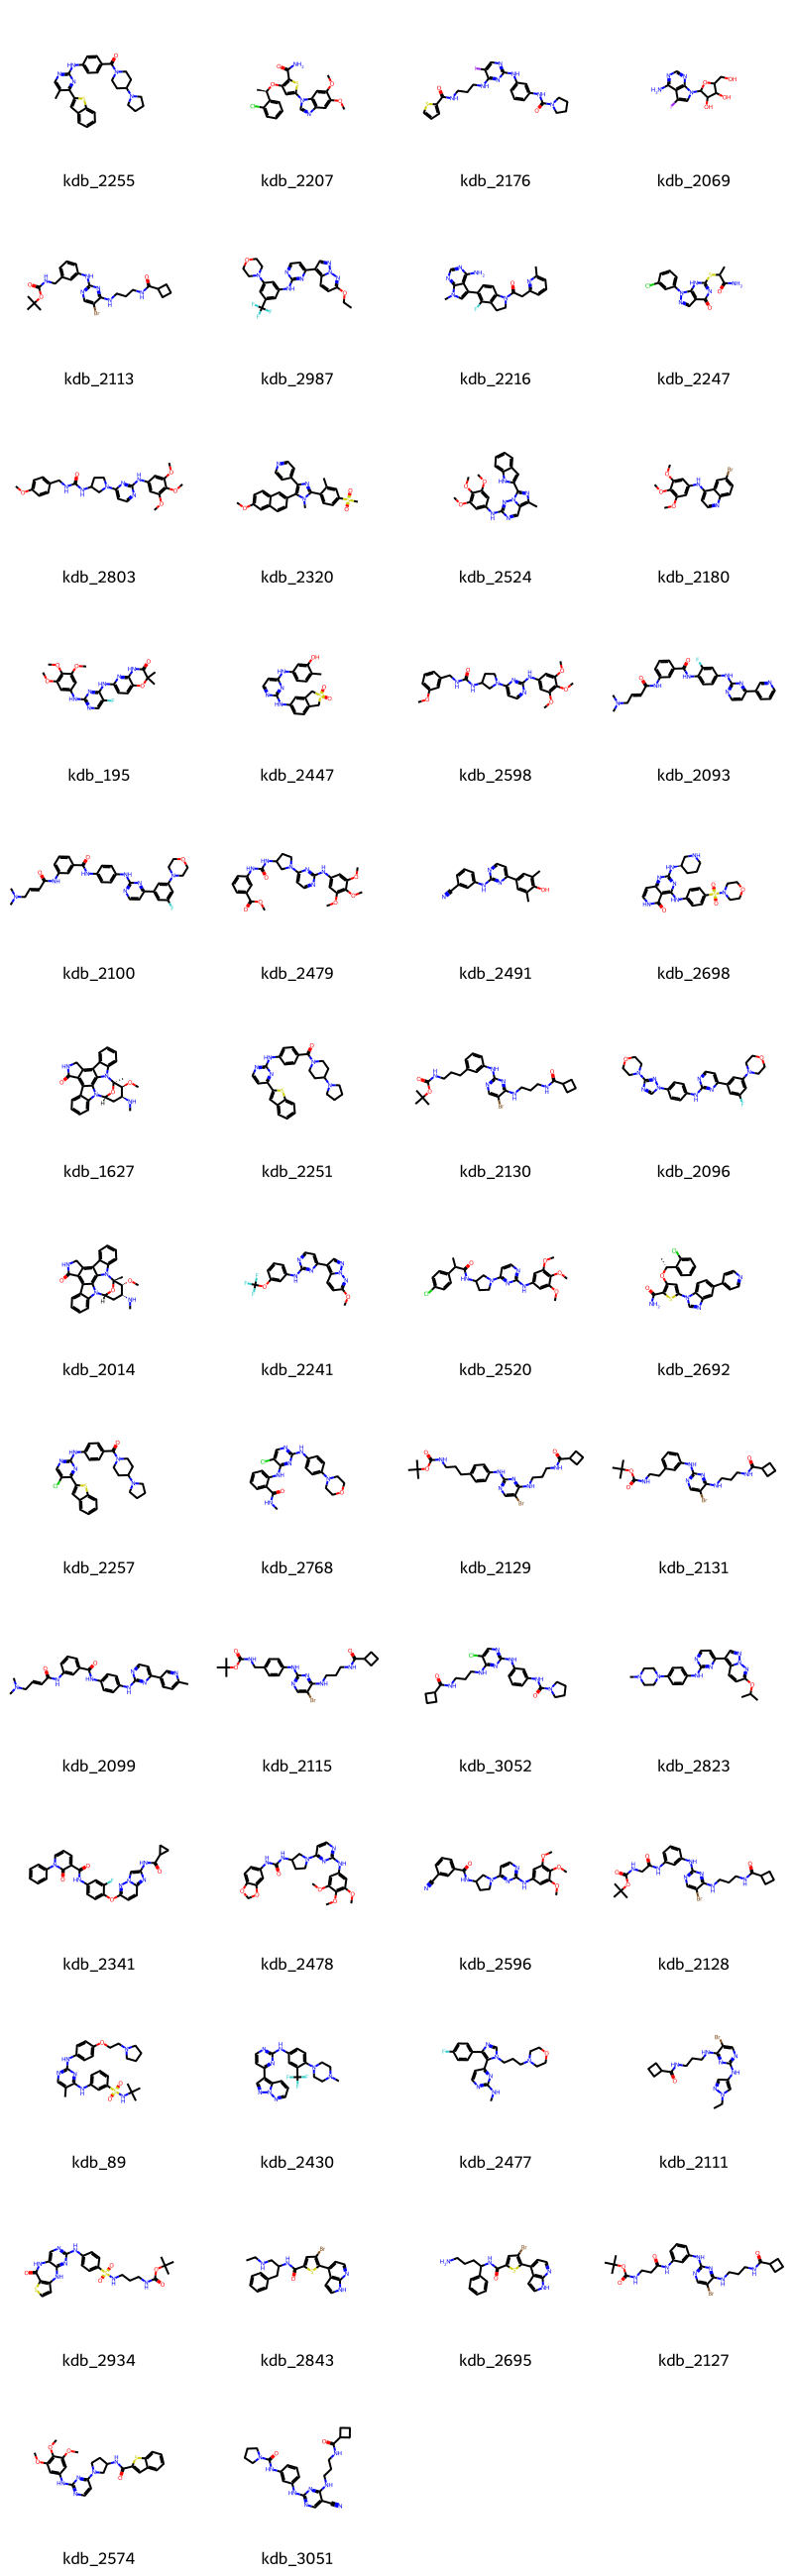

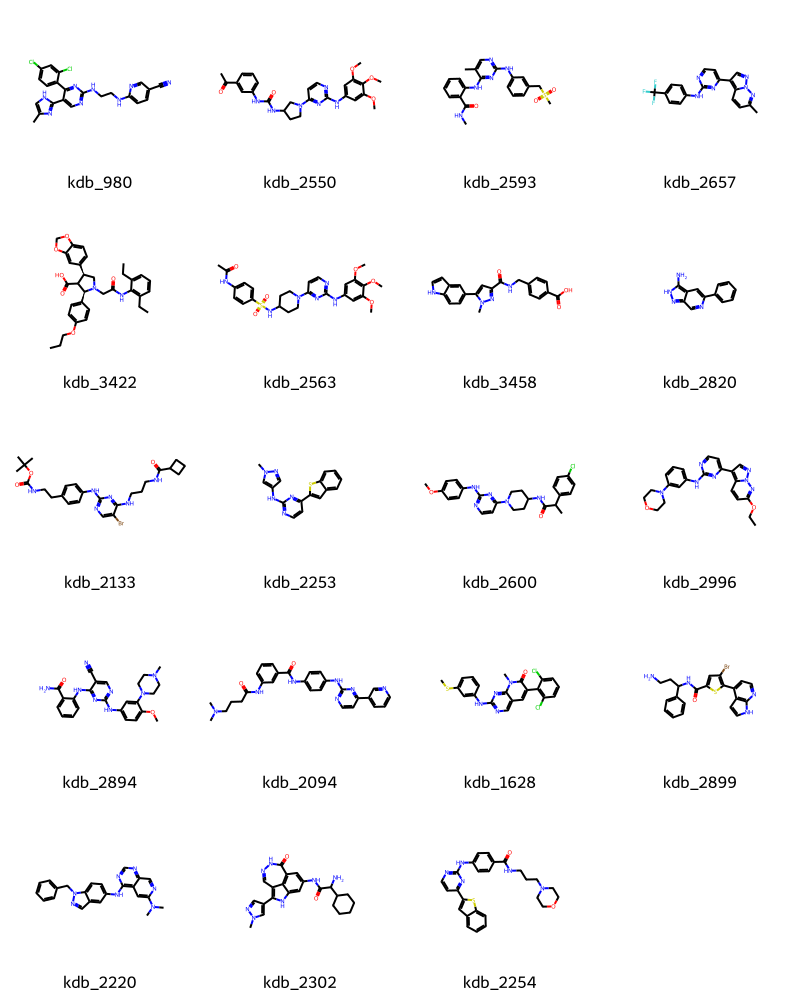

In [111]:
# Diaplaying the active compounds in the training and test set

active_train = []

for m in mol_train:
    if m.GetProp("Active") == '1':
        tmp=Chem.AllChem.Compute2DCoords(m)
        active_train.append(m)

display(Draw.MolsToGridImage(active_train,molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in active_train]))

active_test = []
for m in mol_test:
    if m.GetProp("Active") == '1':
        tmp=Chem.AllChem.Compute2DCoords(m)
        active_test.append(m)

display(Draw.MolsToGridImage(active_test,molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in active_test]))


In [112]:
import os
from rdkit import Chem

# Create the directory if it does not exist
directory = 'data/NEK5'
if not os.path.exists(directory):
    os.makedirs(directory)

# Proceed with writing your files
with Chem.SDWriter(os.path.join(directory, 'NEK5_1_uM_min_50_pct_binding_5fold_random_imbalanced_train.sdf')) as writer:
    for m in mol_train:
        writer.write(m)

with Chem.SDWriter(os.path.join(directory, 'NEK5_1_uM_min_50_pct_binding_5fold_random_imbalanced_test.sdf')) as writer:
    for m in mol_test:
        writer.write(m)


In [113]:
# Generating the existing and morgan fingerprints for the training and test set

X_existing_train = smile_prop_train.drop(columns=['compound_id', 'base_rdkit_smiles', 'active'])
X_existing_test = smile_prop_test.drop(columns=['compound_id', 'base_rdkit_smiles', 'active'])
y_train = smile_prop_train['active']
y_test = smile_prop_test['active']

# generate fingeprints: Morgan fingerprint with radius 2
fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol_train]
# convert the RDKit explicit vectors into numpy arrays
X_morgan_train = []
for fp in fps:
  arr = np.zeros((1,))
  Chem.DataStructs.ConvertToNumpyArray(fp, arr)
  X_morgan_train.append(arr)

# generate fingeprints: Morgan fingerprint with radius 2
fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol_test]
# convert the RDKit explicit vectors into numpy arrays
X_morgan_test = []
for fp in fps:
  arr = np.zeros((1,))
  Chem.DataStructs.ConvertToNumpyArray(fp, arr)
  X_morgan_test.append(arr)


In [114]:
# Function: Random Forest search model generator with stats
def rf_search_model(X_train, y_train, X_test, y_test,random_grid):
    rf = RandomForestClassifier(random_state = 42)
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    y_pred = rf_random.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, precision, recall, conf_matrix

# Function: Random Forest model generator with stats
def rf_model(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(random_state = 42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, precision, recall, conf_matrix



In [115]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [116]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

def plot_category_probabilities(X_train, y_train, X_test, y_test, title=None):
    # Train a Random Forest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Get predicted probabilities
    y_pred_prob = rf_model.predict_proba(X_test)

    # Assign predicted classes based on a threshold of 0.5
    y_pred = (y_pred_prob[:, 1] > 0.5).astype(int)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Extract counts
    TN_count = conf_matrix[0, 0]
    FP_count = conf_matrix[0, 1]
    FN_count = conf_matrix[1, 0]
    TP_count = conf_matrix[1, 1]

    # Calculate probabilities
    total_instances = np.sum(conf_matrix)
    TN_prob = TN_count / total_instances
    FP_prob = FP_count / total_instances
    FN_prob = FN_count / total_instances
    TP_prob = TP_count / total_instances

    # Calculate variance
    TN_var = TN_prob * (1 - TN_prob) / total_instances
    FP_var = FP_prob * (1 - FP_prob) / total_instances
    FN_var = FN_prob * (1 - FN_prob) / total_instances
    TP_var = TP_prob * (1 - TP_prob) / total_instances

    print("Variance of True Negatives:", TN_var)
    print("Variance of False Positives:", FP_var)
    print("Variance of False Negatives:", FN_var)
    print("Variance of True Positives:", TP_var)

    # Obtain the probabilities for each category
    TN_probabilities = y_pred_prob[(y_test == 0) & (y_pred == 0), 0]  # Probabilities of true negatives (TN)
    FN_probabilities = y_pred_prob[(y_test == 1) & (y_pred == 0), 0]  # Probabilities of false negatives (FN)
    FP_probabilities = y_pred_prob[(y_test == 0) & (y_pred == 1), 1]  # Probabilities of false positives (FP)
    TP_probabilities = y_pred_prob[(y_test == 1) & (y_pred == 1), 1]  # Probabilities of true positives (TP)

    # Create a DataFrame containing the data
    data = {
        'Category': ['TN'] * len(TN_probabilities) + ['FP'] * len(FP_probabilities) + ['TP'] * len(TP_probabilities) + ['FN'] * len(FN_probabilities),
        'Probability': list(TN_probabilities) + list(FP_probabilities) + list(TP_probabilities) + list(FN_probabilities)
    }
    df = pd.DataFrame(data)

    # Plot the swarm plot
    plt.figure(figsize=(10, 6))
    sns.swarmplot(x='Category', y='Probability', data=df, size=5)

    # Add labels and title
    plt.xlabel('Category')
    plt.ylabel('Probability')
    plt.title(title if title else 'Probability for Each Category')

    # Show the plot
    plt.grid(True)
    plt.show()




Accuracy: 0.9311740890688259
Recall: 0.10526315789473684
Precision: 1.0


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 RF Model w/ RD kit Fingerprints')

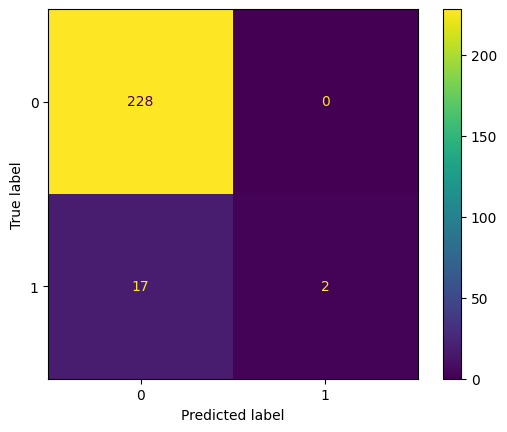

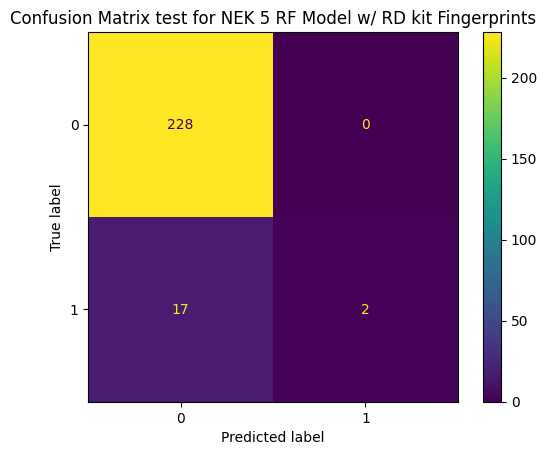

In [117]:
# RF model with existing fingerprints
accuracy, precision, recall, conf_matrix = rf_model(X_existing_train, y_train, X_existing_test, y_test)


print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 RF Model w/ RD kit Fingerprints')



Variance of True Negatives: 0.00028747334882495254
Variance of False Positives: 0.0
Variance of False Negatives: 0.0002594692506707214
Variance of True Positives: 3.251660686154821e-05


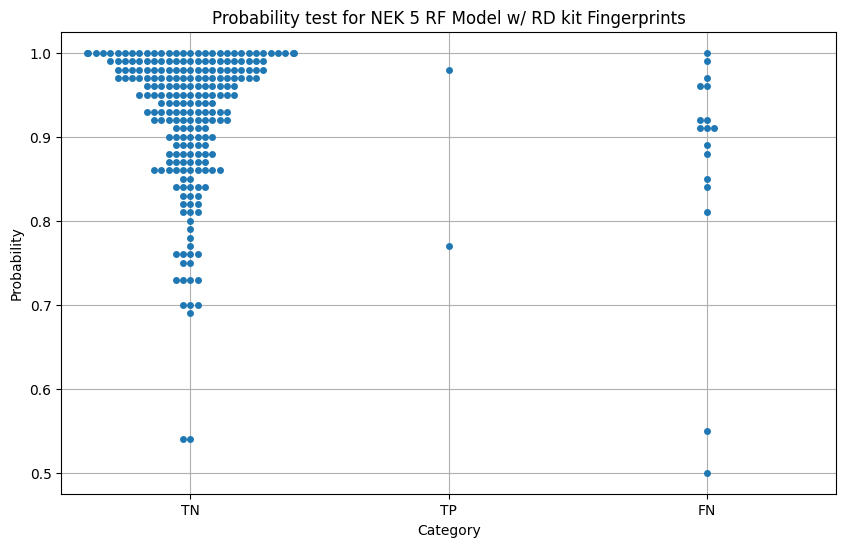

In [118]:

plot_category_probabilities(X_existing_train, y_train, X_existing_test, y_test, title='Probability test for NEK 5 RF Model w/ RD kit Fingerprints')


Accuracy: 0.9352226720647774
Recall: 0.2631578947368421
Precision: 0.7142857142857143


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 RF Model w/ Morgan Fingerprints')

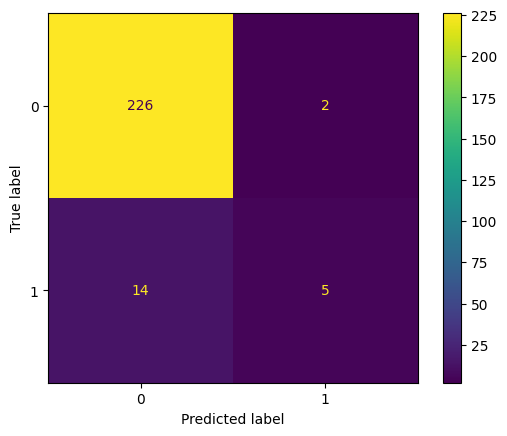

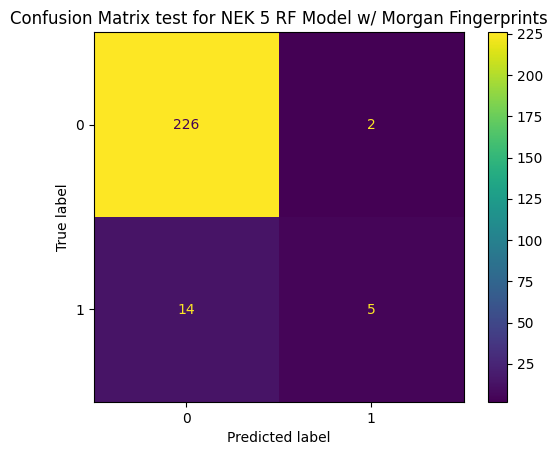

In [119]:
# RF model with morgan fingerprints
accuracy, precision, recall, conf_matrix = rf_model(X_morgan_train, y_train, X_morgan_test, y_test)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 RF Model w/ Morgan Fingerprints')

Variance of True Negatives: 0.0003149465636018527
Variance of False Positives: 3.251660686154821e-05
Variance of False Negatives: 0.00021646769710687803
Variance of True Positives: 8.029611082137414e-05


/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 30.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 35.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


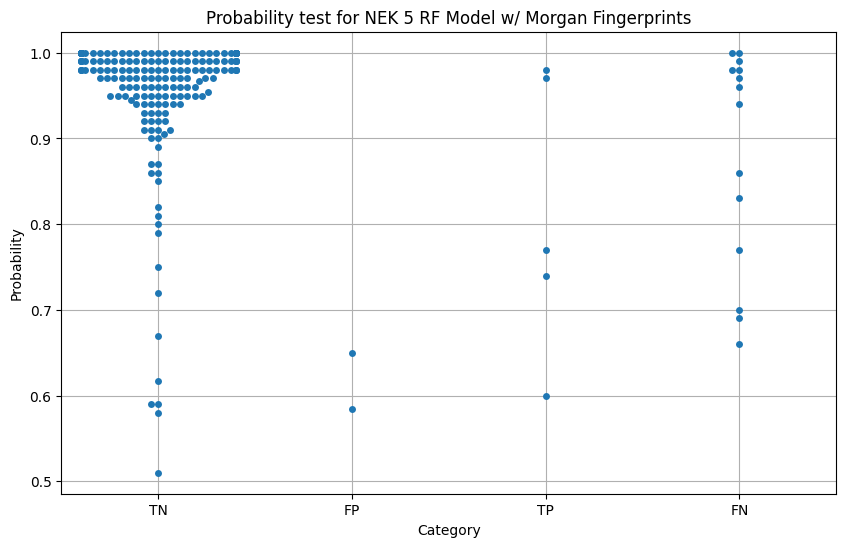

In [120]:
plot_category_probabilities(X_morgan_train, y_train, X_morgan_test, y_test, title='Probability test for NEK 5 RF Model w/ Morgan Fingerprints')


Accuracy: 0.9392712550607287
Recall: 0.21052631578947367
Precision: 1.0


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 RF Model w/ RD kit and oversampling')

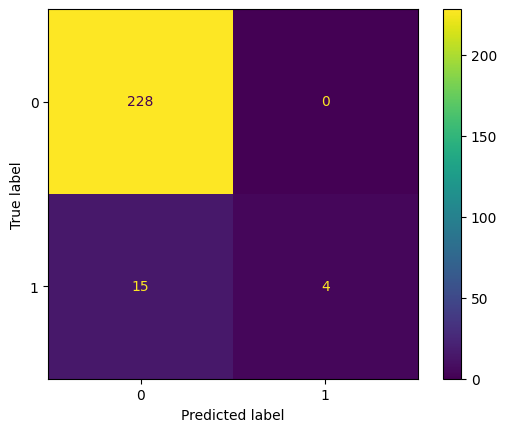

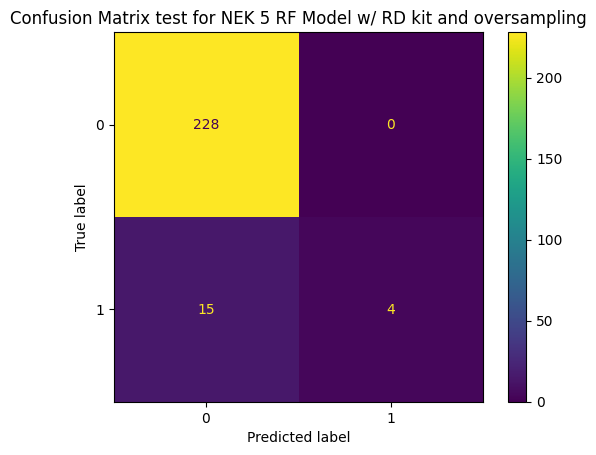

In [121]:
# RF model with existing fingerprints using oversampling
oversample = imb.over_sampling.RandomOverSampler()
X_os_train, y_os_train = oversample.fit_resample(X_existing_train, y_train)

accuracy, precision, recall, conf_matrix = rf_model(X_os_train, y_os_train, X_existing_test, y_test)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 RF Model w/ RD kit and oversampling')

Variance of True Negatives: 0.00028747334882495254
Variance of False Positives: 0.0
Variance of False Negatives: 0.00023093426913915863
Variance of True Positives: 6.4502330345765e-05


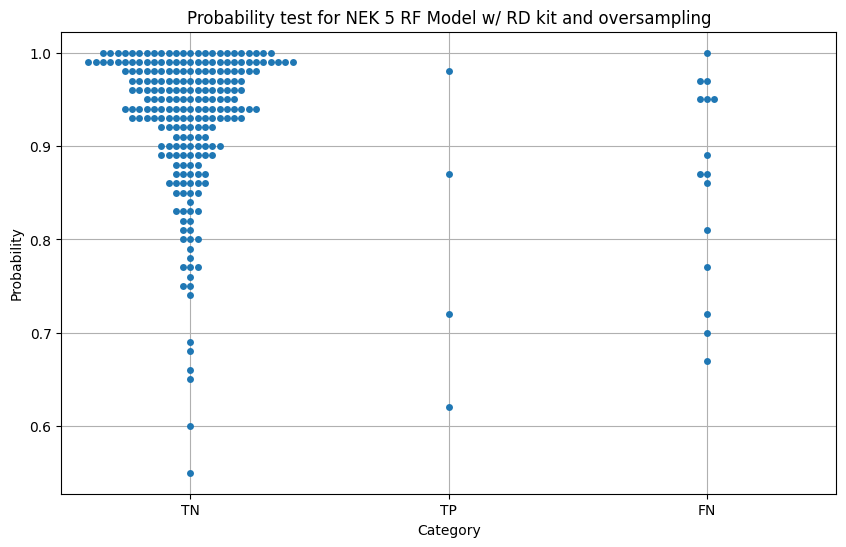

In [122]:
plot_category_probabilities(X_os_train, y_os_train, X_existing_test, y_test, title='Probability test for NEK 5 RF Model w/ RD kit and oversampling')


Accuracy: 0.9271255060728745
Recall: 0.3684210526315789
Precision: 0.5384615384615384


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 RF Model w/ Morgan Fingerprint and oversampling')

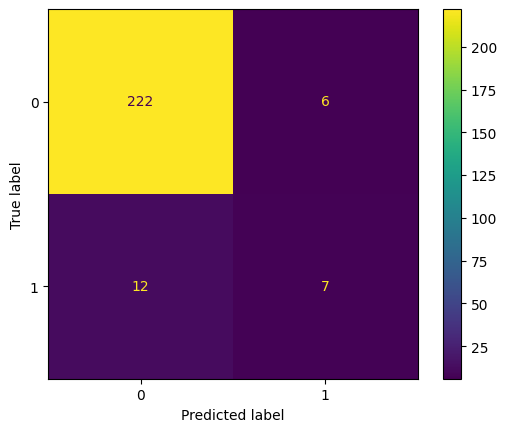

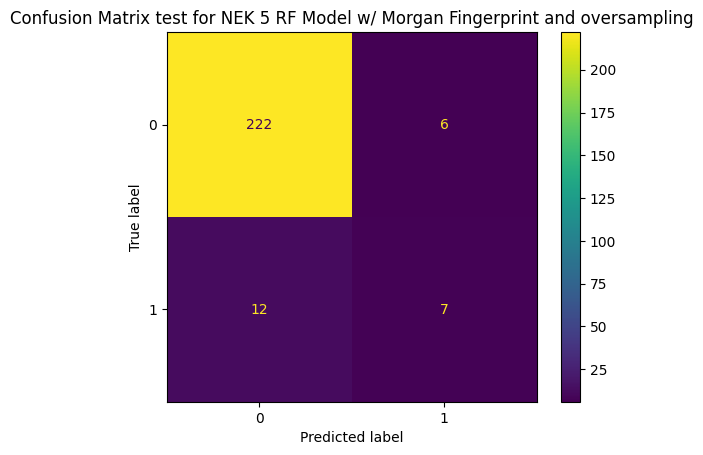

In [123]:
# RF model with morgan fingerprints using oversampling
oversample = imb.over_sampling.RandomOverSampler()
X_os_train, y_os_train = oversample.fit_resample(X_morgan_train, y_train)

accuracy, precision, recall, conf_matrix = rf_model(X_os_train, y_os_train, X_morgan_test, y_test)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 RF Model w/ Morgan Fingerprint and oversampling')

Variance of True Negatives: 0.00036830034302365804
Variance of False Positives: 9.595717045265041e-05
Variance of False Negatives: 0.00018713639050931823
Variance of True Positives: 0.00011148550923959383


/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 24.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 30.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


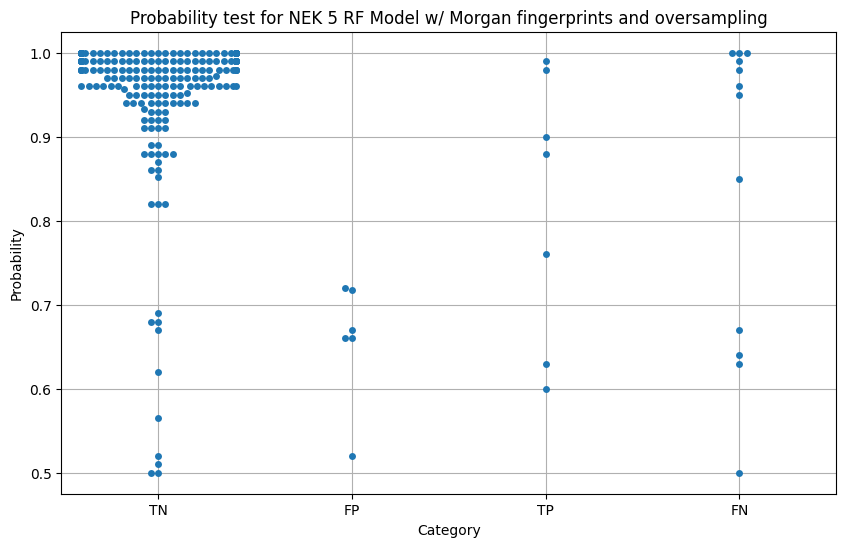

In [124]:
plot_category_probabilities(X_os_train, y_os_train, X_morgan_test, y_test, title='Probability test for NEK 5 RF Model w/ Morgan fingerprints and oversampling')

Accuracy: 0.7813765182186235
Recall: 0.631578947368421
Precision: 0.2033898305084746


Text(0.5, 1.0, 'Confusion Matrix for NEK 5 RF Model w/ RD kit and Under Sampling')

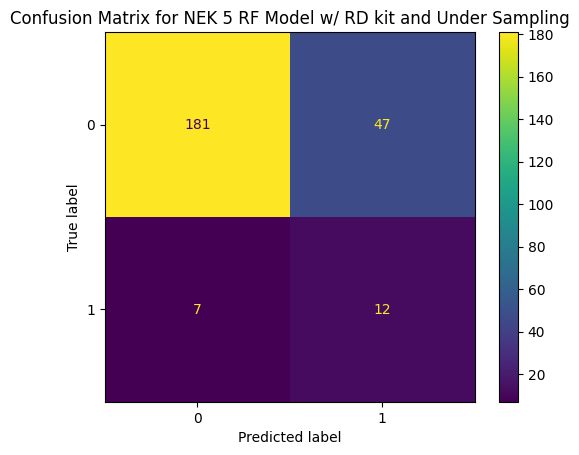

In [125]:


# Initialize the under-sampler
undersample = RandomUnderSampler()

# Apply the under-sampler to the training data
X_us_train, y_us_train = undersample.fit_resample(X_existing_train, y_train)

# Assuming rf_model is defined and works correctly
accuracy, precision, recall, conf_matrix = rf_model(X_us_train, y_us_train, X_existing_test, y_test)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
# Create and display the confusion matrix with a title

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
ax = disp.plot().ax_
ax.set_title('Confusion Matrix for NEK 5 RF Model w/ RD kit and Under Sampling')

Variance of True Negatives: 0.0007927416032001118
Variance of False Positives: 0.0006237879683643941
Variance of False Negatives: 0.00011148550923959383
Variance of True Positives: 0.00018713639050931823


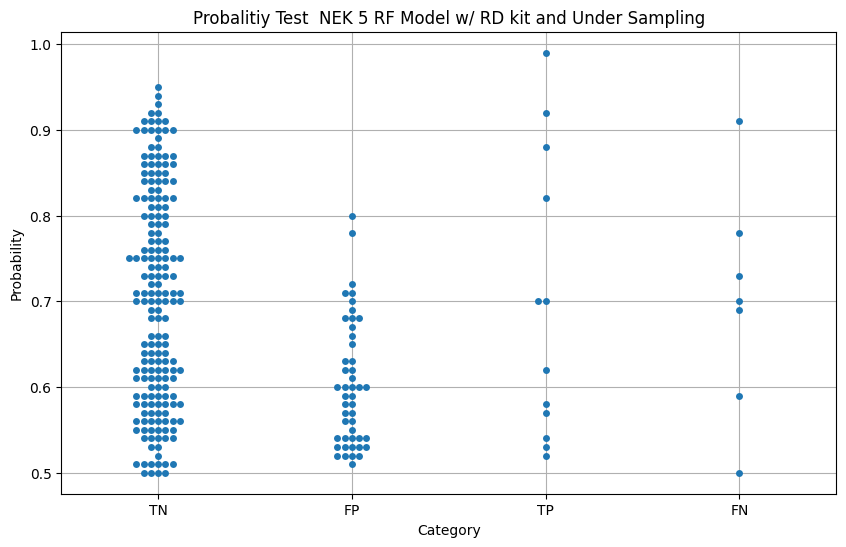

In [126]:
plot_category_probabilities(X_us_train, y_us_train, X_existing_test, y_test, title=('Probalitiy Test  NEK 5 RF Model w/ RD kit and Under Sampling'))

Accuracy: 0.8421052631578947
Recall: 0.6842105263157895
Precision: 0.2826086956521739


Text(0.5, 1.0, 'Confusion Matrix for NEK 5 RF Model Morgan Fingerprint and Under Sampling')

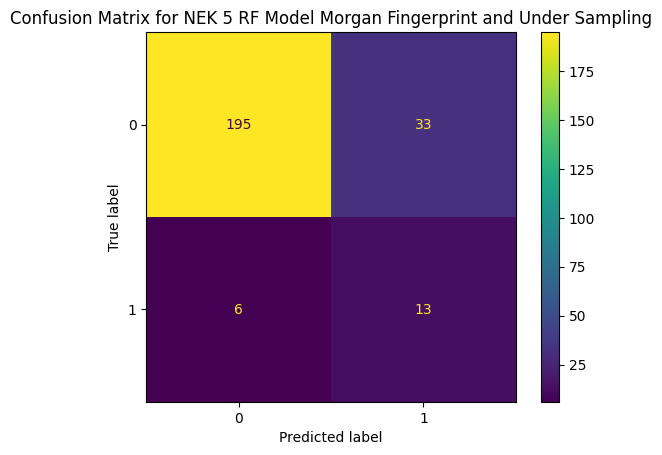

In [127]:
# Initialize the under-sampler
undersample = RandomUnderSampler()

# Apply the under-sampler to the training data
X_us_train, y_us_train = undersample.fit_resample(X_morgan_train, y_train)

# Assuming rf_model is defined and works correctly
accuracy, precision, recall, conf_matrix = rf_model(X_us_train, y_us_train, X_morgan_test, y_test)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
ax = disp.plot().ax_
ax.set_title('Confusion Matrix for NEK 5 RF Model Morgan Fingerprint and Under Sampling')

Variance of True Negatives: 0.0006728946807675485
Variance of False Positives: 0.0004686373013392927
Variance of False Negatives: 9.595717045265041e-05
Variance of True Positives: 0.00020186840423026456


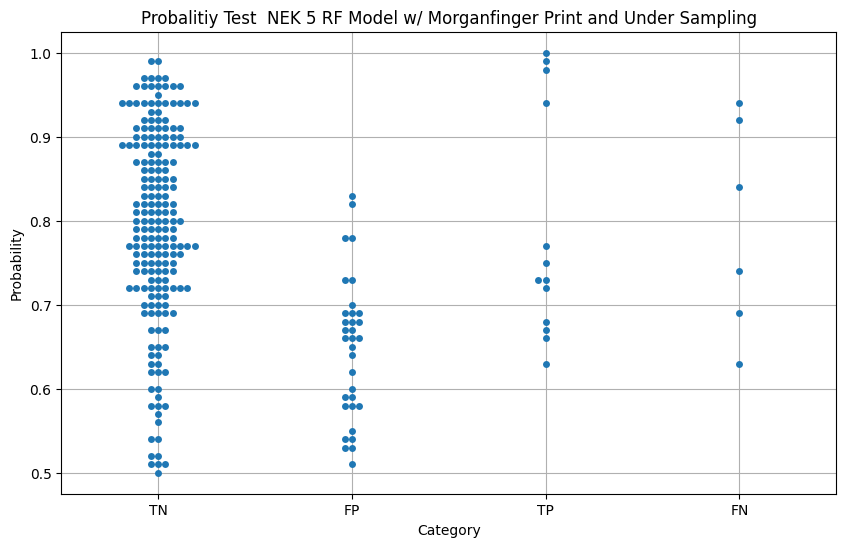

In [128]:
plot_category_probabilities(X_us_train, y_us_train, X_morgan_test, y_test, title=('Probalitiy Test  NEK 5 RF Model w/ Morganfinger Print and Under Sampling'))

Accuracy: 0.9311740890688259
Recall: 0.6842105263157895
Precision: 0.2826086956521739


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 RF Model w/  Morgan Fingerprint and oversampling')

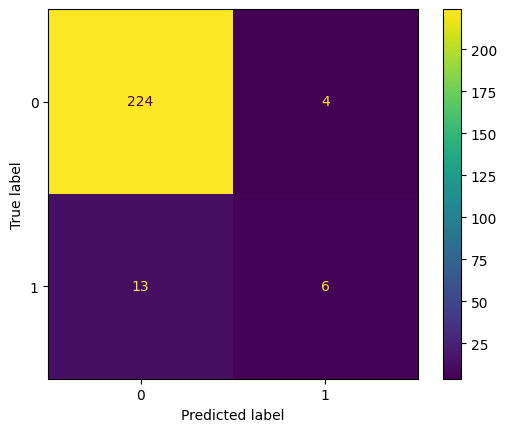

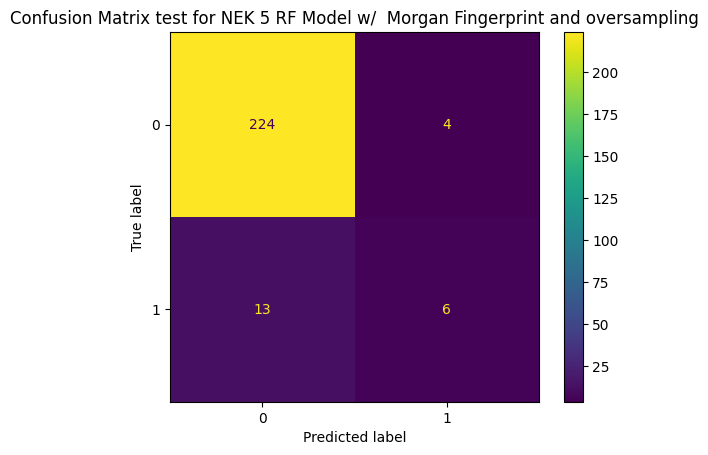

In [129]:

xgb_model = xgb.XGBClassifier(objective='binary:logistic')
xgb_model.fit(X_morgan_train, y_train)
accuracy = xgb_model.score(X_morgan_test, y_test)
conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_morgan_test))

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 RF Model w/  Morgan Fingerprint and oversampling')

Accuracy: 0.9392712550607287
Recall: 0.6842105263157895
Precision: 0.2826086956521739


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 XG Boost Model w/ RD kit')

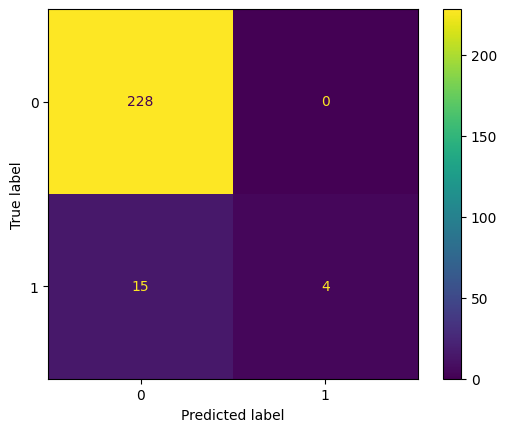

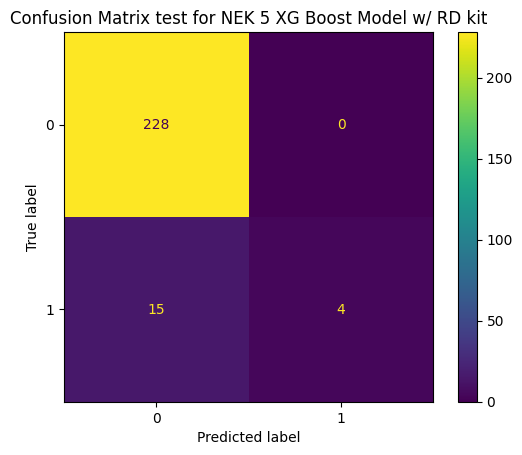

In [130]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic')
xgb_model.fit(X_existing_train, y_train)
accuracy = xgb_model.score(X_existing_test, y_test)
conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_existing_test))

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 XG Boost Model w/ RD kit')

Accuracy: 0.9271255060728745
Recall: 0.6842105263157895
Precision: 0.2826086956521739


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 XG Boost Model w/ Morgan Fingerprint')

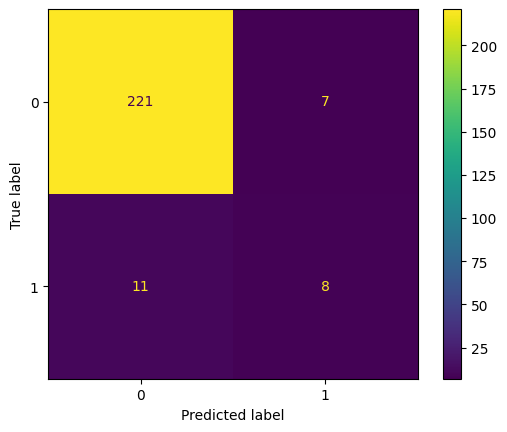

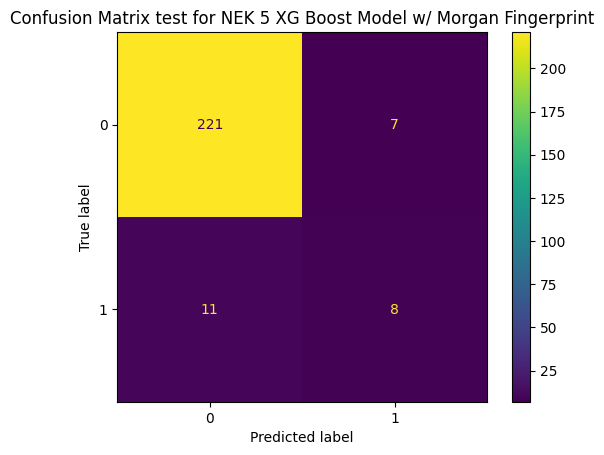

In [131]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic')
X_os_train, y_os_train = oversample.fit_resample(X_morgan_train, y_train)

xgb_model.fit(X_os_train, y_os_train)
accuracy = xgb_model.score(X_morgan_test, y_test)
conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_morgan_test))

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 XG Boost Model w/ Morgan Fingerprint')

Accuracy: 0.9311740890688259
Recall: 0.6842105263157895
Precision: 0.2826086956521739


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 XG Boost Model w/ Morgan Fingerprint')

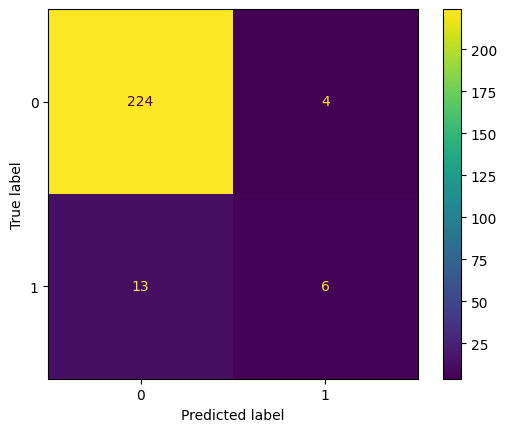

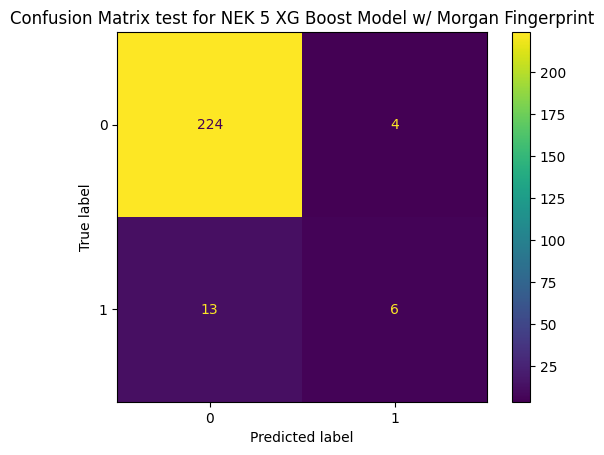

In [132]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic')
xgb_model.fit(X_morgan_train, y_train)
accuracy = xgb_model.score(X_morgan_test, y_test)
conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_morgan_test))

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 XG Boost Model w/ Morgan Fingerprint')